In [1]:
import os
import sys
import  time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from skimage.io import imread
from keras import backend as K
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import  img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from TV_UNET import get_unet, TV_bin_loss
from tensorflow.keras.metrics import Recall, Precision

In [2]:
'''#########################################################################'''

im_width = 128
im_height = 128
EpoachesNo=100
BatcheSZE=32
num_class=2

'''#########################################################################'''

#loading Masks & images then save & labeling loop

path = os.path.join(os.getcwd(), 'Dataset2/')
print(path)

ids1 = next(os.walk(path + 'LungInfection-train/Pseudo-label/Imgs/'))[2]

train = np.zeros((len(ids1), im_width, im_height,1), dtype=np.float32)

mask = np.zeros((len(ids1), im_height, im_width,num_class), dtype=np.float32)

print("No. of Images = ", len(ids1))

sys.stdout.flush()

for n, id_ in tqdm(enumerate(ids1), total=len(ids1)): 
    img = imread(path+'LungInfection-train/Pseudo-label/Imgs/'+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    train[n,:,:] =  x_img

    mask_ID, ext = os.path.splitext(path+'LungInfection-train/Pseudo-label/GT/'+id_)
    msk= imread(mask_ID+'.png')
    msk = resize(msk, (im_width, im_height), mode = 'constant',preserve_range = True, anti_aliasing=False)
    msk=np.round(msk/255)

    for i in range(0, num_class):
        mask[n,:,:,i] = np.where(msk ==i,1,0)
            
'''#########################################################################'''
#loading Masks & images then save & labeling loop
ids2 = next(os.walk(path + 'LungInfection-train/Doctor-label/Imgs/'))[2]

X_train = np.zeros((len(ids2), im_width, im_height,1), dtype=np.float32)

X_mask = np.zeros((len(ids2), im_height, im_width,num_class), dtype=np.float32)

print("No. of Images = ", len(ids2))

sys.stdout.flush()

for n, id_ in tqdm(enumerate(ids2), total=len(ids2)): 
    img = imread(path+'LungInfection-train/Doctor-label/Imgs/'+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    X_train[n,:,:] =  x_img


    mask_ID, ext = os.path.splitext(path+'LungInfection-train/Doctor-label/GT/'+id_)
    msk= imread(mask_ID+'.png')
    msk = resize(msk, (im_width, im_height), mode = 'constant',preserve_range = True, anti_aliasing=False)
    msk=np.round(msk/255)

    for i in range(0, num_class):
        X_mask[n,:,:,i] = np.where(msk ==i,1,0)

train=np.vstack((train,X_train))

mask=np.vstack((mask,X_mask))

'''#########################################################################'''

def dice_coef(y_pred, y_true):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def my_loss(y_true, y_pred):
    layer_names=[layer.name for layer in model.layers]
    for l in layer_names:
        if l==layer_names[-1]:
            value = TV_bin_loss(y_true, y_pred)
        else:
            value = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
    return value


/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/
No. of Images =  1405


  0%|          | 0/1405 [00:00<?, ?it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_10


  0%|          | 5/1405 [00:00<01:59, 11.73it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_39
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_105
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_78
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_8


  1%|          | 10/1405 [00:00<01:22, 16.99it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_103
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_41
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_83


  1%|          | 16/1405 [00:01<01:24, 16.42it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_175
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_25
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_79


  1%|▏         | 20/1405 [00:01<01:18, 17.56it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_59
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_99
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_18


  2%|▏         | 23/1405 [00:01<01:08, 20.17it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_139
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_79


  2%|▏         | 28/1405 [00:01<01:15, 18.30it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_73


  2%|▏         | 32/1405 [00:01<01:00, 22.66it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_41
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_71


  2%|▏         | 35/1405 [00:01<01:07, 20.44it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_76
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_9


  3%|▎         | 40/1405 [00:02<01:25, 16.02it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_41
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_53
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_123
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_104


  3%|▎         | 44/1405 [00:02<01:19, 17.21it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_83
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_66


  3%|▎         | 48/1405 [00:02<01:17, 17.60it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_108
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_149


  4%|▍         | 53/1405 [00:03<01:16, 17.78it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_95
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

  4%|▍         | 59/1405 [00:03<01:12, 18.49it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_40
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_62


  4%|▍         | 62/1405 [00:03<01:04, 20.76it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_133
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_44


  5%|▍         | 68/1405 [00:03<01:04, 20.60it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_206
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_148
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_40


  5%|▌         | 71/1405 [00:03<01:01, 21.81it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_92
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_112
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_88
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_45
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

  6%|▌         | 78/1405 [00:04<01:06, 20.00it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_87
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_31


  6%|▌         | 82/1405 [00:04<00:57, 23.19it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_72
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_96
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_116
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVI

  6%|▋         | 88/1405 [00:04<00:51, 25.71it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_93
/data/jwd/main/040/914/40914875/working/jupyte

  7%|▋         | 92/1405 [00:04<00:44, 29.20it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_96
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_27


  7%|▋         | 100/1405 [00:05<00:53, 24.52it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_127
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

  8%|▊         | 107/1405 [00:05<00:46, 28.05it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_96
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_118
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_87
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_7
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_122
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

  8%|▊         | 114/1405 [00:05<00:48, 26.62it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_79
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_91
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungI

  8%|▊         | 118/1405 [00:05<00:44, 28.92it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_185
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lun

  9%|▉         | 127/1405 [00:05<00:43, 29.11it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_170
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_94
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_179
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COV

 10%|▉         | 134/1405 [00:06<01:07, 18.83it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_90
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_136


 10%|▉         | 137/1405 [00:06<01:11, 17.71it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_69
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_157
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_11


 10%|█         | 143/1405 [00:06<00:58, 21.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_132
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_189
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

 10%|█         | 146/1405 [00:06<00:55, 22.83it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_119


 11%|█         | 149/1405 [00:07<01:03, 19.76it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_99
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_16


 11%|█         | 154/1405 [00:07<01:18, 15.96it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_90
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_52


 11%|█▏        | 160/1405 [00:07<01:02, 19.94it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_102
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_160
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_102


 12%|█▏        | 166/1405 [00:08<00:59, 20.87it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_98
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_89
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_191
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_24


 12%|█▏        | 169/1405 [00:08<01:04, 19.06it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_68
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_86
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_6


 12%|█▏        | 174/1405 [00:08<01:07, 18.34it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_59
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_76
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_116


 13%|█▎        | 179/1405 [00:08<00:58, 20.94it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_124
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_141
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_76


 13%|█▎        | 182/1405 [00:08<00:55, 21.97it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_62


 13%|█▎        | 188/1405 [00:09<01:20, 15.07it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_119
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/

 14%|█▍        | 194/1405 [00:09<01:02, 19.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_69
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_54


 14%|█▍        | 197/1405 [00:09<01:03, 18.88it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_80
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_95
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/

 14%|█▍        | 203/1405 [00:10<00:53, 22.51it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_41
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_165
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_73
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 15%|█▍        | 209/1405 [00:10<00:57, 20.84it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_102
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_13


 15%|█▌        | 215/1405 [00:10<00:56, 20.91it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_160
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_1


 16%|█▌        | 224/1405 [00:10<00:38, 30.39it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_92
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_83
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_120
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

 16%|█▌        | 228/1405 [00:11<00:43, 27.08it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_137
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid

 17%|█▋        | 235/1405 [00:11<00:39, 29.54it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_133
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_68
/data/jwd/main/040/914/40914875/working/jupyt

 17%|█▋        | 243/1405 [00:11<00:41, 27.81it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_93
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_108
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVI

 18%|█▊        | 250/1405 [00:11<00:37, 30.78it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_111
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_81
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_101
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lu

 18%|█▊        | 254/1405 [00:11<00:35, 32.34it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_95
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_131
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_

 19%|█▊        | 262/1405 [00:12<00:37, 30.46it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_81
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_158


 19%|█▉        | 266/1405 [00:12<00:42, 26.99it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_172
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_39
/data/jwd/main

 19%|█▉        | 273/1405 [00:12<00:38, 29.23it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_98
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_66
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_169
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

 20%|██        | 281/1405 [00:12<00:38, 29.57it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_86
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_73
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_128
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_93
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covi

 20%|██        | 285/1405 [00:13<00:43, 25.93it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_132
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_90
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_87
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_21


 20%|██        | 288/1405 [00:13<00:51, 21.64it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_78
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_20


 21%|██        | 291/1405 [00:13<00:58, 19.03it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_80
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_7
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_19


 21%|██        | 296/1405 [00:13<01:00, 18.33it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_145
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_55


 22%|██▏       | 303/1405 [00:13<00:44, 24.92it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_72
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_95
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_39
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

 22%|██▏       | 310/1405 [00:14<00:43, 25.24it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_110
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_197
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lu

 22%|██▏       | 316/1405 [00:14<00:40, 26.65it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_174
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_39
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_53
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_113


 23%|██▎       | 319/1405 [00:14<00:39, 27.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_79
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_71
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_113
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_7
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_9


 23%|██▎       | 325/1405 [00:14<00:44, 24.22it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_124
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_76
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_78


 24%|██▎       | 331/1405 [00:15<00:40, 26.21it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_68
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_91
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

 24%|██▍       | 338/1405 [00:15<00:35, 29.81it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_125
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_7
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-

 25%|██▍       | 346/1405 [00:15<00:35, 30.13it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_84
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

 25%|██▌       | 354/1405 [00:15<00:31, 33.78it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_76
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_104
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_124
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 25%|██▌       | 358/1405 [00:15<00:30, 34.86it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

 26%|██▌       | 366/1405 [00:16<00:34, 30.33it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_71
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_72
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/

 27%|██▋       | 374/1405 [00:16<00:30, 33.30it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_39
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_102
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_88
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_101
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_135
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-labe

 27%|██▋       | 378/1405 [00:16<00:36, 28.05it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_77
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_34


 27%|██▋       | 385/1405 [00:16<00:39, 25.78it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_12


 28%|██▊       | 388/1405 [00:16<00:38, 26.21it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_59
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_17


 28%|██▊       | 391/1405 [00:17<00:44, 22.96it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_139
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_104
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_37


 28%|██▊       | 397/1405 [00:17<00:46, 21.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_79
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_28


 29%|██▊       | 403/1405 [00:17<00:46, 21.45it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_92
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_43


 29%|██▉       | 409/1405 [00:17<00:40, 24.40it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_92
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_202
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_68
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_25
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 29%|██▉       | 412/1405 [00:18<00:46, 21.58it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_112
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_4


 30%|██▉       | 418/1405 [00:18<00:50, 19.64it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_41


 30%|██▉       | 421/1405 [00:18<00:46, 21.16it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_148
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_53


 30%|███       | 427/1405 [00:18<00:53, 18.17it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_85
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_139
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_6


 31%|███       | 431/1405 [00:19<00:52, 18.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_117
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_96
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_19


 31%|███       | 437/1405 [00:19<00:41, 23.57it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_115
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_88
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_95
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covi

 32%|███▏      | 445/1405 [00:19<00:36, 26.62it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_106
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_114
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

 32%|███▏      | 451/1405 [00:19<00:34, 27.44it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_109
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_143
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_80
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_103
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_00

 33%|███▎      | 458/1405 [00:20<00:35, 26.72it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_68
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_105
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_97
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungI

 33%|███▎      | 464/1405 [00:20<00:33, 27.75it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_184
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-

 34%|███▎      | 471/1405 [00:20<00:30, 31.03it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_195
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 34%|███▍      | 475/1405 [00:20<00:34, 27.33it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_7
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_66
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT

 34%|███▍      | 481/1405 [00:20<00:33, 27.79it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_25
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-

 35%|███▍      | 489/1405 [00:21<00:33, 27.16it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_151
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_111
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lun

 35%|███▌      | 493/1405 [00:21<00:31, 29.39it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_106
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_73
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_73
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lun

 36%|███▌      | 500/1405 [00:21<00:33, 27.24it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_199
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_194
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lu

 36%|███▌      | 508/1405 [00:21<00:29, 30.58it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_168
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_105
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_121
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/L

 37%|███▋      | 515/1405 [00:22<00:32, 27.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_84


 37%|███▋      | 518/1405 [00:22<00:40, 21.91it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_88
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_115


 37%|███▋      | 521/1405 [00:22<00:44, 19.68it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_140
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 38%|███▊      | 528/1405 [00:22<00:40, 21.63it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_136
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_107
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_126


 38%|███▊      | 534/1405 [00:23<00:41, 20.91it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_162
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_81


 38%|███▊      | 537/1405 [00:23<00:46, 18.71it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_73
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_187
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_17


 38%|███▊      | 540/1405 [00:23<00:49, 17.44it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_129


 39%|███▉      | 546/1405 [00:23<00:46, 18.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_120
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_114
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_38


 39%|███▉      | 552/1405 [00:24<00:45, 18.95it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_8


 40%|███▉      | 555/1405 [00:24<00:41, 20.39it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_137
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_83
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_45


 40%|███▉      | 561/1405 [00:24<00:40, 20.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_101
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_98
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_95
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_8


 40%|████      | 567/1405 [00:24<00:40, 20.72it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_96
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT

 41%|████      | 574/1405 [00:25<00:32, 25.52it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_84
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

 41%|████      | 577/1405 [00:25<00:37, 21.99it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_43
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_57
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT

 42%|████▏     | 585/1405 [00:25<00:28, 28.45it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_108
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_87
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_119
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_69
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label

 42%|████▏     | 593/1405 [00:25<00:30, 26.97it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_125
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_149
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_143
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_78
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/L

 43%|████▎     | 600/1405 [00:25<00:26, 30.12it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_180
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_165
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVI

 43%|████▎     | 608/1405 [00:26<00:27, 28.88it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_106
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_

 44%|████▎     | 612/1405 [00:26<00:25, 30.69it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_45
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID

 44%|████▍     | 616/1405 [00:26<00:24, 31.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_90
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_104
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_50


 44%|████▍     | 623/1405 [00:26<00:31, 24.84it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_146
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_113
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_84
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_4


 45%|████▍     | 626/1405 [00:27<00:37, 20.77it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_161
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_43
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_2


 45%|████▍     | 629/1405 [00:27<00:41, 18.81it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_91
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_151
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_122
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_158


 45%|████▌     | 635/1405 [00:27<00:40, 19.12it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_75
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_127
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_77
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_89
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_97


 46%|████▌     | 641/1405 [00:27<00:33, 22.52it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_53
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_114
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 46%|████▌     | 647/1405 [00:28<00:35, 21.37it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_41
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_78
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_69


 47%|████▋     | 654/1405 [00:28<00:28, 26.33it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_164
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_78
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 47%|████▋     | 660/1405 [00:28<00:26, 27.60it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_133
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_57
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 47%|████▋     | 667/1405 [00:28<00:28, 26.00it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_83
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_57
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungIn

 48%|████▊     | 675/1405 [00:28<00:23, 31.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_89
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_97
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lung

 49%|████▊     | 683/1405 [00:29<00:21, 33.24it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_22
/data/jwd/main/040/914/40914875/working/jupyter/c

 49%|████▉     | 687/1405 [00:29<00:24, 29.63it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_76
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_66
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

 49%|████▉     | 695/1405 [00:29<00:21, 32.81it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_83
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_80
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_136
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 50%|████▉     | 699/1405 [00:29<00:20, 33.68it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_7


 50%|█████     | 706/1405 [00:30<00:28, 24.88it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_52


 51%|█████     | 713/1405 [00:30<00:28, 24.59it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_87
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 51%|█████     | 719/1405 [00:30<00:26, 25.95it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_85
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_122
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_39


 52%|█████▏    | 726/1405 [00:30<00:22, 30.04it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_142
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_78
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_39
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_

 52%|█████▏    | 734/1405 [00:31<00:27, 24.24it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_153
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_135
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 53%|█████▎    | 743/1405 [00:31<00:21, 31.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_41
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_102
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 53%|█████▎    | 751/1405 [00:31<00:22, 29.19it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_57
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_8

 54%|█████▎    | 755/1405 [00:31<00:25, 25.90it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_73
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_5


 54%|█████▍    | 758/1405 [00:31<00:25, 25.72it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_114
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_163
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_135
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_109
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_32


 54%|█████▍    | 765/1405 [00:32<00:24, 25.69it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_91
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_119
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_183
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lu

 55%|█████▍    | 771/1405 [00:32<00:23, 26.99it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_166
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_37


 55%|█████▌    | 774/1405 [00:32<00:27, 23.16it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_44
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_75
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_81
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_72
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_4

 56%|█████▌    | 781/1405 [00:32<00:29, 21.45it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_105
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_26


 56%|█████▌    | 784/1405 [00:33<00:32, 19.12it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_99
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_46


 56%|█████▌    | 787/1405 [00:33<00:34, 17.95it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_111
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_142
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_76


 56%|█████▋    | 791/1405 [00:33<00:37, 16.57it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_108
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_130
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_58


 57%|█████▋    | 794/1405 [00:33<00:31, 19.12it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_141
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_7


 57%|█████▋    | 800/1405 [00:34<00:31, 19.10it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_113
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_75


 57%|█████▋    | 803/1405 [00:34<00:33, 17.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_80


 57%|█████▋    | 805/1405 [00:34<00:39, 15.36it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_57


 57%|█████▋    | 807/1405 [00:34<00:44, 13.56it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_203
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_82
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_57
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_37


 58%|█████▊    | 814/1405 [00:35<00:38, 15.54it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_39


 58%|█████▊    | 816/1405 [00:35<00:36, 16.04it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_68


 58%|█████▊    | 820/1405 [00:35<00:33, 17.47it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_97
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_150
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_75


 59%|█████▉    | 826/1405 [00:35<00:29, 19.57it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_94
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_7


 59%|█████▉    | 832/1405 [00:35<00:28, 20.30it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_106
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_176


 59%|█████▉    | 835/1405 [00:36<00:30, 18.39it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_25
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_85
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_8


 60%|█████▉    | 839/1405 [00:36<00:34, 16.45it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_94


 60%|█████▉    | 841/1405 [00:36<00:33, 16.81it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_111


 60%|██████    | 845/1405 [00:36<00:36, 15.19it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_65


 60%|██████    | 849/1405 [00:37<00:33, 16.84it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_111
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_87


 61%|██████    | 854/1405 [00:37<00:32, 16.99it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_40
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_82


 61%|██████    | 858/1405 [00:37<00:33, 16.20it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_86
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_53
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_10


 61%|██████▏   | 862/1405 [00:37<00:31, 17.35it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_126
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_32


 62%|██████▏   | 868/1405 [00:38<00:28, 18.95it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_121
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_79


 62%|██████▏   | 871/1405 [00:38<00:24, 21.58it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_123
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_25
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_2


 62%|██████▏   | 874/1405 [00:38<00:23, 22.52it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_53
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_99
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_51


 63%|██████▎   | 880/1405 [00:38<00:27, 18.90it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_167
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_78


 63%|██████▎   | 883/1405 [00:38<00:25, 20.61it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_94
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_86
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_2


 63%|██████▎   | 886/1405 [00:39<00:27, 18.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_182
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_84


 63%|██████▎   | 891/1405 [00:39<00:32, 15.76it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_59


 64%|██████▎   | 894/1405 [00:39<00:28, 18.17it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_114
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_101
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_82
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_18


 64%|██████▍   | 900/1405 [00:39<00:25, 19.61it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_97
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_108


 64%|██████▍   | 905/1405 [00:40<00:26, 18.73it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_53


 65%|██████▍   | 909/1405 [00:40<00:25, 19.08it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_140
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_120
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_69
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_54


 65%|██████▌   | 915/1405 [00:40<00:25, 19.02it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_89
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_150
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_93
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_57


 65%|██████▌   | 918/1405 [00:40<00:23, 20.73it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_4


 66%|██████▌   | 924/1405 [00:41<00:22, 21.52it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_71


 66%|██████▌   | 927/1405 [00:41<00:25, 18.71it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_66
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_49


 66%|██████▌   | 930/1405 [00:41<00:26, 17.69it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_77
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_134


 67%|██████▋   | 936/1405 [00:41<00:25, 18.46it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_82
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_4


 67%|██████▋   | 939/1405 [00:41<00:26, 17.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_25


 67%|██████▋   | 944/1405 [00:42<00:27, 17.03it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_105
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_51


 67%|██████▋   | 946/1405 [00:42<00:36, 12.55it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_138
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_40


 68%|██████▊   | 950/1405 [00:42<00:36, 12.53it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_143
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_69
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_112


 68%|██████▊   | 956/1405 [00:43<00:28, 15.78it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_112
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_90
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_8


 68%|██████▊   | 958/1405 [00:43<00:27, 16.24it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_59
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_90
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_22


 68%|██████▊   | 962/1405 [00:43<00:29, 15.22it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_15


 69%|██████▊   | 964/1405 [00:43<00:32, 13.70it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_68
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_5


 69%|██████▉   | 968/1405 [00:43<00:28, 15.51it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_69


 69%|██████▉   | 971/1405 [00:44<00:28, 15.35it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_155
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_92
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_102


 69%|██████▉   | 976/1405 [00:44<00:26, 16.11it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_127
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_190
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_8


 70%|██████▉   | 980/1405 [00:44<00:24, 17.37it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_72
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_26


 70%|██████▉   | 983/1405 [00:44<00:21, 20.06it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_99
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_75


 70%|███████   | 988/1405 [00:45<00:22, 18.89it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_30


 71%|███████   | 992/1405 [00:45<00:25, 16.04it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_154
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_71
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_36


 71%|███████   | 997/1405 [00:45<00:20, 19.43it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_131
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_2


 71%|███████   | 1000/1405 [00:45<00:18, 21.60it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_85
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_30
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_1

 72%|███████▏  | 1006/1405 [00:45<00:18, 21.77it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_154
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_98
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_72


 72%|███████▏  | 1012/1405 [00:46<00:18, 21.29it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_90


 72%|███████▏  | 1015/1405 [00:46<00:24, 16.11it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_105
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_126
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_42


 73%|███████▎  | 1019/1405 [00:46<00:26, 14.80it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_159
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_54


 73%|███████▎  | 1024/1405 [00:47<00:23, 16.55it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_20


 73%|███████▎  | 1030/1405 [00:47<00:19, 19.16it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_77
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_110
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_23
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_43
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_18


 74%|███████▎  | 1033/1405 [00:47<00:17, 21.37it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_152
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_41


 74%|███████▍  | 1039/1405 [00:47<00:15, 23.95it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_90
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_177
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVI

 75%|███████▍  | 1047/1405 [00:48<00:13, 27.36it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_106
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covi

 75%|███████▍  | 1053/1405 [00:48<00:15, 23.20it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_128
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_39
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

 75%|███████▌  | 1060/1405 [00:48<00:12, 27.43it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_116
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_79
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covi

 76%|███████▌  | 1063/1405 [00:48<00:12, 27.90it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_33


 76%|███████▌  | 1066/1405 [00:48<00:14, 23.40it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_118
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_134


 76%|███████▋  | 1073/1405 [00:49<00:16, 20.04it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_68
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_153
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_39
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

 77%|███████▋  | 1080/1405 [00:49<00:13, 24.18it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_7


 77%|███████▋  | 1083/1405 [00:49<00:15, 21.11it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_75
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_68
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_178
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_56
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_14


 78%|███████▊  | 1089/1405 [00:49<00:15, 20.36it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_87
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_32


 78%|███████▊  | 1092/1405 [00:50<00:16, 18.72it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_130
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_117
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_104
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_116


 78%|███████▊  | 1098/1405 [00:50<00:14, 21.86it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_92
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_109


 78%|███████▊  | 1101/1405 [00:50<00:15, 20.26it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_81
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_48
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_35


 79%|███████▉  | 1107/1405 [00:50<00:14, 20.47it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_109
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_76
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_17


 79%|███████▉  | 1110/1405 [00:51<00:15, 18.63it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_144
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_1


 79%|███████▉  | 1116/1405 [00:51<00:17, 16.08it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_81


 80%|███████▉  | 1120/1405 [00:51<00:16, 17.08it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_25
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_26


 80%|███████▉  | 1122/1405 [00:51<00:15, 17.74it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_75


 80%|████████  | 1128/1405 [00:51<00:12, 22.30it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_103
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_111
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_40
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lun

 81%|████████  | 1135/1405 [00:52<00:11, 24.18it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_106
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_94
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_88
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_5


 81%|████████  | 1141/1405 [00:52<00:12, 21.18it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_43
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_52
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_4


 81%|████████▏ | 1144/1405 [00:52<00:11, 22.06it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_53
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID

 82%|████████▏ | 1150/1405 [00:52<00:11, 22.50it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_122
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_147
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_115
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_114
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_27


 82%|████████▏ | 1156/1405 [00:53<00:11, 21.18it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_101
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_18
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_50
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_109


 82%|████████▏ | 1159/1405 [00:53<00:12, 19.13it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_40
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_10


 83%|████████▎ | 1165/1405 [00:53<00:11, 20.03it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_71
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_99
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_112


 83%|████████▎ | 1171/1405 [00:53<00:09, 23.83it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_128
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_85
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/Lun

 84%|████████▍ | 1178/1405 [00:54<00:09, 24.97it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_1
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_53
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_85
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19

 84%|████████▍ | 1186/1405 [00:54<00:07, 30.90it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_95
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_88
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 85%|████████▍ | 1190/1405 [00:54<00:06, 32.78it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_133
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_4

 85%|████████▍ | 1194/1405 [00:54<00:07, 28.09it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_14


 85%|████████▌ | 1198/1405 [00:54<00:08, 24.60it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_161
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_20


 86%|████████▌ | 1204/1405 [00:55<00:11, 17.65it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_8
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_129
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_43


 86%|████████▌ | 1207/1405 [00:55<00:10, 19.09it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_137
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_60
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_59
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_59
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_130


 86%|████████▋ | 1214/1405 [00:55<00:08, 21.24it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_155
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_129
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_141
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/L

 87%|████████▋ | 1220/1405 [00:56<00:07, 24.40it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_26
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_12
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_128
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 87%|████████▋ | 1223/1405 [00:56<00:07, 24.77it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_192
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_120
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_104
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-labe

 88%|████████▊ | 1231/1405 [00:56<00:06, 26.63it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_20
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_7
/data/jwd/main/040/914/40914875/working/jupyter

 88%|████████▊ | 1237/1405 [00:56<00:06, 26.68it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_141
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_123
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_142
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_59
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label

 88%|████████▊ | 1241/1405 [00:56<00:06, 25.04it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_73
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_21


 89%|████████▉ | 1247/1405 [00:57<00:07, 22.38it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_7
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_69
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_14


 89%|████████▉ | 1250/1405 [00:57<00:07, 20.30it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_131
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_97
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_3


 89%|████████▉ | 1255/1405 [00:57<00:08, 18.51it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_55
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_32


 90%|████████▉ | 1259/1405 [00:57<00:08, 16.62it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_34


 90%|████████▉ | 1262/1405 [00:58<00:07, 19.12it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_20


 90%|█████████ | 1268/1405 [00:58<00:06, 19.97it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_58
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_117
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_70
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVI

 91%|█████████ | 1275/1405 [00:58<00:05, 25.98it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_28
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_201
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_37
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVI

 91%|█████████ | 1278/1405 [00:58<00:05, 22.92it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_13
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_87


 91%|█████████ | 1281/1405 [00:58<00:06, 19.57it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_64
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_17
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_173


 92%|█████████▏| 1286/1405 [00:59<00:07, 15.32it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_101
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_3


 92%|█████████▏| 1291/1405 [00:59<00:06, 18.45it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_11
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_118


 92%|█████████▏| 1294/1405 [00:59<00:05, 20.96it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_115
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_132
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_45
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003

 93%|█████████▎| 1301/1405 [00:59<00:04, 23.93it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_97
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_112
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_65
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_93
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_47
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covi

 93%|█████████▎| 1310/1405 [01:00<00:04, 22.61it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_10
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_140
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_98
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 93%|█████████▎| 1313/1405 [01:00<00:03, 24.03it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_31
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_2
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_80
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_91
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungI

 94%|█████████▍| 1320/1405 [01:00<00:03, 28.06it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_80
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_45
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_32
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_67
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/G

 94%|█████████▍| 1326/1405 [01:00<00:03, 23.51it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_36
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_74
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_29
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_207
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_35


 95%|█████████▍| 1329/1405 [01:01<00:03, 24.71it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_96
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_5
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_58


 95%|█████████▌| 1335/1405 [01:01<00:03, 19.59it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_57
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_35
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_107
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_146


 95%|█████████▌| 1338/1405 [01:01<00:03, 21.77it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_25
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_107
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_71
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_37


 96%|█████████▌| 1344/1405 [01:01<00:03, 18.25it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_4
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_63
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_79
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_46
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_002_36


 96%|█████████▌| 1350/1405 [01:02<00:02, 18.95it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_24
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_33
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_2


 96%|█████████▋| 1353/1405 [01:02<00:02, 20.56it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_61
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_118
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_156
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_117


 97%|█████████▋| 1356/1405 [01:02<00:02, 19.12it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_111
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm_21
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_43
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_82


 97%|█████████▋| 1365/1405 [01:02<00:01, 23.80it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_62
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_77
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_27
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_71
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_89
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_3

 98%|█████████▊| 1371/1405 [01:03<00:01, 23.60it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_171
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_16
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_34


 98%|█████████▊| 1374/1405 [01:03<00:01, 20.23it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_3
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_135
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_109
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_006_76
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_99


 98%|█████████▊| 1380/1405 [01:03<00:01, 23.52it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_140
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_9
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_86
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_101
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_42
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/

 99%|█████████▊| 1386/1405 [01:04<00:01, 16.77it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm_22
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_14
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_34
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_010_38
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm_15


 99%|█████████▉| 1389/1405 [01:04<00:00, 18.83it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_009_6
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_66
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_94
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_107


 99%|█████████▉| 1395/1405 [01:04<00:00, 16.97it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_49
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_007_98
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_001_100
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_54


 99%|█████████▉| 1397/1405 [01:04<00:00, 17.24it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_15
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm_19
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_003_41
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_138


100%|█████████▉| 1403/1405 [01:05<00:00, 14.30it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_54
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_51
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_77
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_005_121
/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_004_40


100%|██████████| 1405/1405 [01:05<00:00, 21.53it/s]

/data/jwd/main/040/914/40914875/working/jupyter/covid_ct_segmentation/COVID-CT-Segmentation/Dataset2/LungInfection-train/Pseudo-label/GT/Data-1_coronacases_org_008_103
No. of Images =  50



100%|██████████| 50/50 [00:02<00:00, 17.20it/s]


In [3]:
'''#########################################################################'''
############ Applying TV_UNET Model

input_img = Input((im_height, im_width,1), name='img')

model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True)

model.compile(optimizer=Adam(learning_rate=0.001) , loss = [my_loss], metrics=['accuracy',dice_loss,Recall(name='recall_1'),
                                                            Precision(name='pre_1')])
model.summary()

'''#########################################################################'''
############ Split train and validation
X_train, X_valid, y_train, y_valid = train_test_split(train, mask, test_size=0.1, random_state=42)

callbacks = [
    EarlyStopping(patience=50, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-TV-UNet1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

'''#########################################################################'''
'''Test'''
#loading Masks & image-test then save & labeling loop
ids3 = next(os.walk(path + 'LungInfection-test/Imgs/'))[2]

y = np.zeros((len(ids3), im_width, im_height,1), dtype=np.float32)

label_test = np.zeros((len(ids3), im_height, im_width,num_class), dtype=np.float32)

print("No. of Images = ", len(ids3))

sys.stdout.flush()

for n, id_ in tqdm(enumerate(ids3), total=len(ids3)): 
            img = imread(path+'LungInfection-test/Imgs/'+id_)
            x_img = img_to_array(img)
            x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
            y[n,:,:] =  x_img


            mask_ID, ext = os.path.splitext(path+'LungInfection-test/GT/'+id_)
            msk= imread(mask_ID+'.png')
            msk = resize(msk, (im_width, im_height), mode = 'constant',preserve_range = True)
            msk=np.round(msk/255)
            
            for i in range(0, num_class):
              label_test[n,:,:,i] = np.where(msk ==i,1,0)
'''#########################################################################'''           


2022-02-10 15:00:23.749283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 15:00:24.522021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 15:00:24.522557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 15:00:24.524381: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

2022-02-10 15:00:36.617213: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-02-10 15:00:41.371909: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


41/41 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9550 - dice_loss: 0.1975 - recall_1: 0.9190 - pre_1: 0.9581
Epoch 00001: val_loss improved from inf to 7.80206, saving model to model-TV-UNet1.h5
41/41 [==============================] - 60s 821ms/step - loss: 0.2448 - accuracy: 0.9550 - dice_loss: 0.1975 - recall_1: 0.9190 - pre_1: 0.9581 - val_loss: 7.8021 - val_accuracy: 0.8156 - val_dice_loss: 0.3776 - val_recall_1: 0.8434 - val_pre_1: 0.4932 - lr: 0.0010
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9700 - dice_loss: 0.0886 - recall_1: 0.9690 - pre_1: 0.9706
Epoch 00002: val_loss improved from 7.80206 to 1.96404, saving model to model-TV-UNet1.h5
41/41 [==============================] - 22s 537ms/step - loss: 0.1172 - accuracy: 0.9700 - dice_loss: 0.0886 - recall_1: 0.9690 - pre_1: 0.9706 - val_loss: 1.9640 - val_accuracy: 0.9592 - val_dice_loss: 0.1427 - val_recall_1: 0.7721 - val_pre_1: 0.9597 - lr: 0.0010
Epo

100%|██████████| 48/48 [00:02<00:00, 23.80it/s]


'#########################################################################'

In [4]:
########## load the best model


model.load_weights('model-TV-UNet1.h5')

preds_test1 = model.predict(y, verbose=1)

'''#########################################################################'''
############ calculate  recall or Sensitivity
tre=np.arange(0.1,1,0.1).tolist()

y_test_f=K.flatten(label_test[:,:,:,1])

preds_test_f=K.flatten(preds_test1[:,:,:,1])

m = tf.keras.metrics.Recall(thresholds=tre)

m.update_state(y_test_f, preds_test_f)

Recal_TV_unet=m.result().numpy()

print('Sensitivity_TV_unet=',Recal_TV_unet)

'''#########################################################################'''
############ calculate  Specificity
from sklearn.metrics import confusion_matrix

for i in tre:
  y_test_f=K.flatten(label_test[:,:,:,1]>i)
  preds_test_f=K.flatten(preds_test1[:,:,:,1]>i)

  tn, fp, fn, tp=confusion_matrix(y_test_f.numpy(), preds_test_f.numpy()).ravel()
  specificity = tn / (tn+fp)
  
  print('Specificity_TV_unet=', specificity,'\n')

'''#########################################################################'''
#calculate  Dice Score
def dice_coef(y_pred, y_true):
  for tr in np.arange(0.1,1,.1):
    y_pred_t = (y_pred[:,:,:,1] > tr).astype(np.uint8)
    y_true_f = np.array(y_true[:,:,:,1])
    y_pred_f = np.array(y_pred_t)
    intersection = np.sum(y_true_f * y_pred_f)
    sum_ = np.sum(np.abs(y_true_f) + np.abs(y_pred_f))
    print( 2*(intersection) /sum_ )

dice=dice_coef(preds_test1,label_test)

print('DSC_TV_unet=',dice)
'''#########################################################################'''


2/2 [==============================] - 3s 2s/step
Sensitivity_TV_unet= [0.8589769  0.81379455 0.7777733  0.7429033  0.7068741  0.66592056
 0.6161656  0.54976696 0.42766583]
Specificity_TV_unet= 0.9248947967683745 

Specificity_TV_unet= 0.944408238437473 

Specificity_TV_unet= 0.9555764895159669 

Specificity_TV_unet= 0.9638506121671336 

Specificity_TV_unet= 0.9705551918153927 

Specificity_TV_unet= 0.976500705387101 

Specificity_TV_unet= 0.9819245500416579 

Specificity_TV_unet= 0.9873846847078427 

Specificity_TV_unet= 0.9933831212131751 

0.7614903530995872
0.772212487388966
0.7728922888714124
0.7682489294512508
0.7590421947628878
0.7439804229779937
0.7199346176298891
0.6802104763411932
0.584783048309258
DSC_TV_unet= None


'#########################################################################'

2/2 [==============================] - 0s 140ms/step
[20 34 28 41 12]


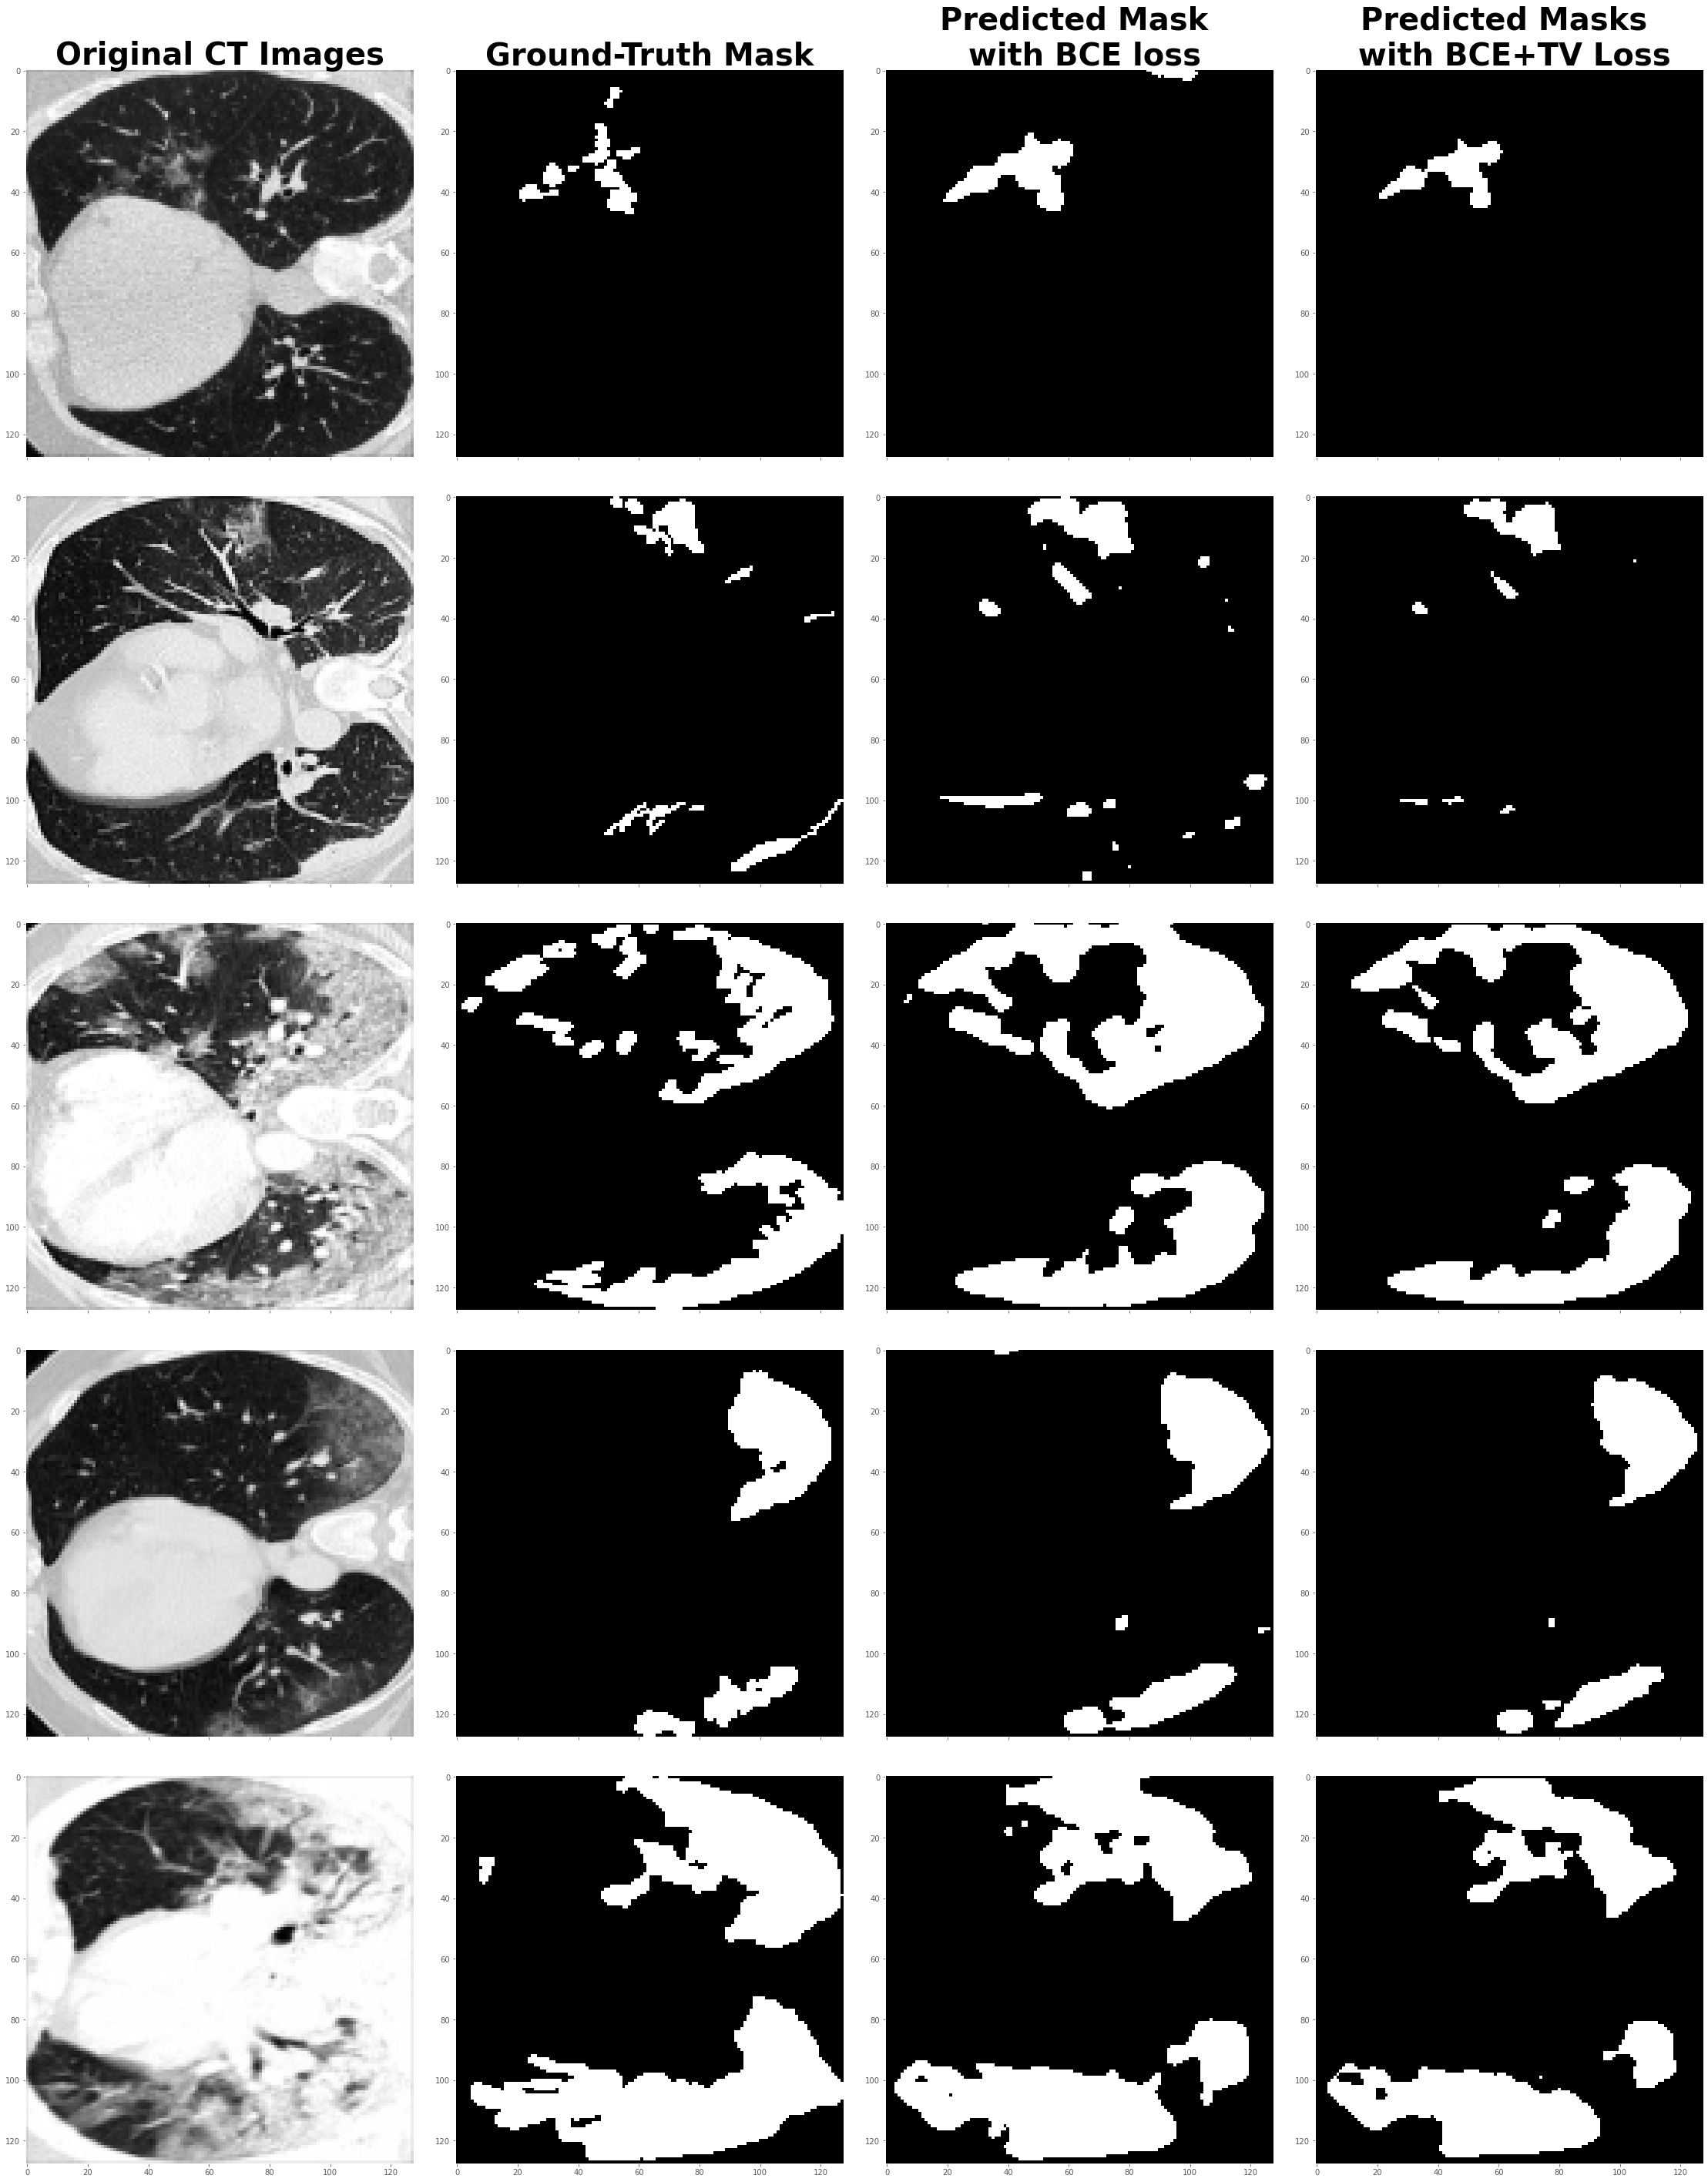

In [6]:
#loaded_model.load_weights("model-TV-UNet2.h5")

preds_test1 = model.predict(y, verbose=1)
preds_test_t1 = (preds_test1 > 0.1).astype(np.uint8)

#model.load_weights('weight-TV-UNet.h5')
preds_test2 = model.predict(y, verbose=1)
preds_test_t2 = (preds_test2 > 0.3).astype(np.uint8)

no_pred = 5
rand_indx = np.random.randint(1, y.shape[0], no_pred)
print(rand_indx)

def plot_sample(X, y, binary_preds1, binary_preds2):
    fig, axs = plt.subplots(5, 4, figsize=(50, 50),sharex='all')
    i = 0

    for ix in rand_indx:
      l = 1

      axs[i,0].imshow(X[ix, ..., 0], cmap='gray')
      axs[0,0].set_title('Original CT Images',fontweight="bold", size=40)

      axs[i,1].imshow(y[ix,:,:,l].squeeze(),cmap='gray')
      axs[0,1].set_title('Ground-Truth Mask',fontweight="bold", size=40)

      axs[i,2].imshow(binary_preds1[ix,:,:,l].squeeze(),cmap='gray', vmin=0, vmax=1)
      axs[0,2].set_title('Predicted Mask \n with BCE loss',fontweight="bold", size=40)
      
      axs[i,3].imshow(binary_preds2[ix,:,:,l].squeeze(),cmap='gray', vmin=0, vmax=1)
      axs[0,3].set_title('Predicted Masks \n with BCE+TV Loss',fontweight="bold", size=40);
      
      i += 1
      
      plt.rcParams["axes.grid"] = False
      plt.subplots_adjust(wspace=-0.5, hspace=0.1)
    plt.savefig("true_pred_dataset2.png")

plot_sample(y, label_test, preds_test_t1, preds_test_t2)
plt.rcParams["axes.grid"] = False